## Анализ событий в стартапе, А/А/В-тест изменения шрифта в приложении

### Описание проекта


### Описание данных
В вашем распоряжении набор данных в котором

Каждая запись в логе — это действие пользователя, или событие.
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


**Цели иследования**:


**Основные этапы работы**:
1. Откройте файл с данными и изучите общую информацию
2. Подготовка данных
3. Изучение и проверка данных
4. Изучите воронку событий
5. Изучите результаты эксперимента

## Загрузка данных и изучение их

In [104]:
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Импортируем библиотеки
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from scipy import stats as st
import numpy as np
from datetime import datetime as dt

Чтение файла

In [44]:
filepath = './dataset/logs_exp.csv'

try:
    data = pd.read_csv(filepath, sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net' + filepath, sep='\t')

Вывод общей информации

In [45]:
data.info()

data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

Набор данных содержит 4 столбца, 244126 строк. Все ячейки заполнены данными, пропущенных значений нет.

Посмотрим выборочно 10 строк данных

In [46]:
data.sample(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
163245,PaymentScreenSuccessful,4705890939205361551,1565016833,246
59393,OffersScreenAppear,9042318653803239039,1564754071,247
34185,MainScreenAppear,6304868067479728361,1564684490,248
7262,MainScreenAppear,2108584058851133928,1564641892,247
45907,OffersScreenAppear,299409047914517767,1564730665,248
167849,OffersScreenAppear,7034504451802426444,1565022614,246
134907,OffersScreenAppear,2300274679097142648,1564940162,248
176385,OffersScreenAppear,6116464130294403607,1565040829,247
124128,MainScreenAppear,5986169048870188421,1564922457,247
33031,OffersScreenAppear,7888067827493510326,1564682686,246


Колонка со временем хранится в секундах. Наименования колонок в верхнем регистре.

Для дальнейшего изучения приведем колоки к общему удобному виду. Добавим колонку со временем

In [47]:
# переименуем колонки
data.columns = ['event_name', 'device_id', 'event_timestamp', 'group']

# добавим колонку с датой события
data['event_date'] = pd.to_datetime(data['event_timestamp'], unit='s')

Просмотрим времменой набор данных за какой промежуток собраны данные

In [48]:
data['event_date'].describe()

count                  244126
unique                 176654
top       2019-08-01 14:40:35
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: event_date, dtype: object

Данные собраны в период с 25 июля по 7 августа включительно

In [49]:
data.describe().apply(lambda x: x.apply('{0:.1f}'.format))

,device_id,event_timestamp,group
count,244126.0,244126.0,244126.0
mean,4627568124590853120.0,1564913915.8,247.0
std,2642424998963707904.0,177134.3,0.8
min,6888746892508752.0,1564029816.0,246.0
25%,2372212476992240640.0,1564756580.2,246.0
50%,4623191541214045184.0,1564919395.0,247.0
75%,6932517045703054336.0,1565074511.0,248.0
max,9222603179720523776.0,1565212517.0,248.0


Можно сказать что аномальнчых значений нет, отрицательных также нету

In [50]:
# Узнать уникальные события
list(data['event_name'].unique())

['MainScreenAppear',
 'PaymentScreenSuccessful',
 'CartScreenAppear',
 'OffersScreenAppear',
 'Tutorial']

В данных есть 5 уникальных событий. И за весь период произошло 244126 события.

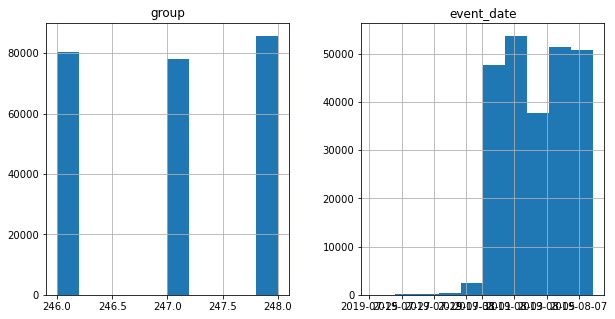

In [51]:
# Посмотрим на даты и номера тестируемых групп в данных событий
data[['group', 'event_date']].hist(figsize=(10, 5));

Групп всего 3, больше всего событий совершила группа 248. Распределение событий по данным не нормальное, все события произошли во второй половине набора данных во времени.

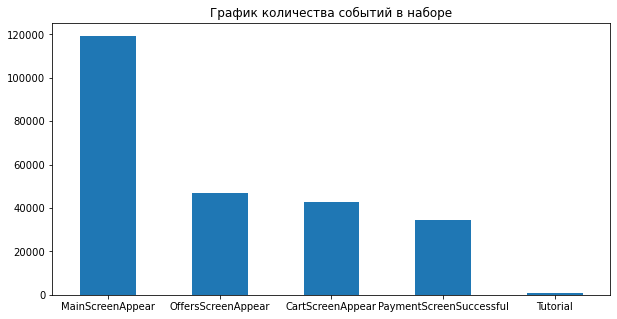

In [52]:
plt.figure(figsize=(10, 5))
data['event_name'].value_counts().plot(kind='bar', rot=0)
plt.title("График количества событий в наборе");

В данном графике мы видим как формируется пользовательская воронка, от просмотра Главной страницы до Успешного платежа. Обучение практически все пропускают. Событий с посетившими главную страницу около 120тысяч.

**Вывод**

- В данных нету пропущенных значений. 
- Колонки не были приведены к общему виду, дата событий хранилась в секундах, что мы исправили сразу, для того что бы узнать временной променой промежуток выборки
- Прослеживается создание потребительской воронки. 

## Подготовить данные к анализу

Добавим колонку с датой

In [53]:
# Добавим колонки с датой, днем недели, и годом евента (пробный возможно потом понадобиться!)
# data = data.assign(
#     date = data['event_date'].astype('datetime64[D]'),
#     days_of_week_event=lambda x : x.event_date.dt.day_name(),
#     month_event=data['event_date'].dt.month_name(),
#     year_event=data['event_date'].dt.year
# )
# display(data.head())

In [54]:
# добавим колонки даты и дня недели
data = data.assign(
    date = data['event_date'].astype('datetime64[D]'),
    days_of_week_event=lambda x : x.event_date.dt.day_name()
)

Необходим просмотреить сколько всего в наборе пользователей, сколько в среднем приходиться событий на одного пользователя, провврим присутсвие пользователя в нескольких группах.  

In [55]:
# Сколько всего уникальных пользователей
cnt_users = data['device_id'].nunique()

cnt_users

7551

В тесте приняло участие 7551 пользователь

In [56]:
# Сгруппируем по девайсам и посчитаем количество событий для каждого 
event_by_users= (
    data.groupby('device_id', as_index=False)
    .agg({'event_name':'count'}).
    rename(columns={'event_name':'cnt_events_user'})
)

print(f'Среднее количество событий на 1 пользователя: {event_by_users["cnt_events_user"].mean():.1f}')

Среднее количество событий на 1 пользователя: 32.3


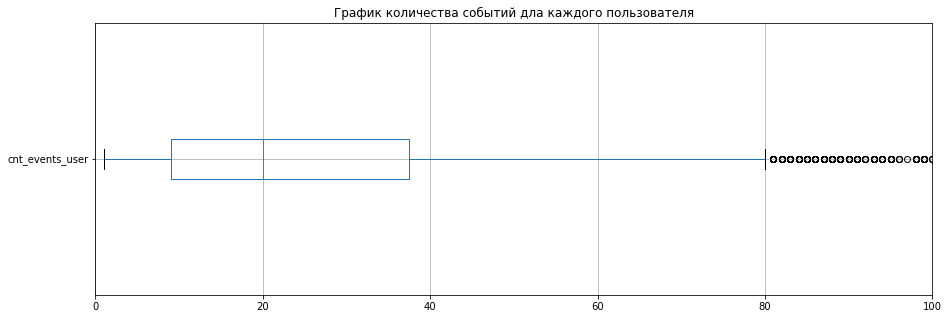

In [57]:
plt.figure(figsize=(15, 5))
plt.xlim(0, 100)
event_by_users.boxplot(column='cnt_events_user', vert=False)
plt.title('График количества событий дла каждого пользователя')
plt.show()

В среднем каждый пользователей за данный период совершил 32 события. Номальное количество событий для одного пользователя от 1 до 80, мединна событий для пользователя равняется 20. Итого максимально нормальный показатель по событиям для пользователя совершить - 80 событий.

In [58]:
# Сгруппируем покупателей и посчитаем их в тестируемых группах,
# каждому пользвателю будет присвоено в скольки группах он участвует
bad_users_group = (
    data.groupby('device_id', as_index=False)
    .agg({'group':pd.Series.nunique})
)

# Вывести группы и сколько в них человек пересекаются
bad_users_group.group.value_counts()

1    7551
Name: group, dtype: int64

Предположение что пользователи плохо разделены и пользователь может участвовать в разных тестируемых группаах не подвердилось. Качество разделения пользователей замечаний не вызывает

In [59]:
# проверим на дубликаты, и сразу посчитаем конверсию ко всей выборке
print(f'Конверсия дибликатов составила: {data.duplicated().sum() / data.shape[0]:.1%}')

Конверсия дибликатов составила: 0.2%


Доля дубликатов значений ко всей выборке составила всего `0.2%`, удаляем их

In [60]:
# Удалить дубликаты, присвоить индексы
data = data.drop_duplicates().reset_index(drop=True)

### Изучим период времени


Изучим детально данные по времени. Вычислим сколько дней это заняло. Как события расределены по времени, есть ли какие-нибудь аномалии.

In [61]:
first_day = data['date'].min() # первый день
last_day = data['date'].max()  # последний день теста
print(last_day-first_day)

13 days 00:00:00


Итого у нас данные собранны за 13 дней тестирования. Сгруппируем под дням и посчитаем сколько произошло событий в каждый день.

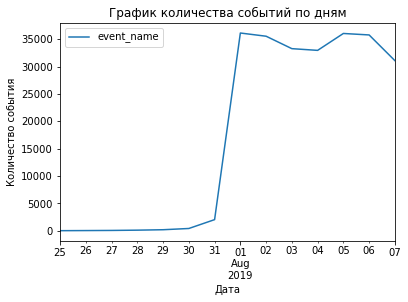

In [62]:
# подсчет событий по дням
cnt_events_by_day = data.groupby('date').agg({'event_name':'count'})

# Визуализация данных
cnt_events_by_day.plot()
plt.title("График количества событий по дням")
plt.xlabel('Дата')
plt.ylabel('Количество события')
plt.show()

Складывается предположение что до 1 августа происходила подготовка к тестированию по группам, в логи попало скудные доля событий от всех данных теста. Так что не вижу смысла рассматривать события раньше 1 августа.

In [63]:
# У нас останутся данные только после 31 августа 2019 года
clean_data = data.query('date > "2019-07-31"')

# Доля потерянных данных
print(f'Потеря данных составила: {clean_data.shape[0]/data.shape[0]-1:.1%}')

# Cколько всего осталось пользователей
print(f'Всего пользвателей : {clean_data["device_id"].nunique()}')

Потеря данных составила: -1.2%
Всего пользвателей : 7534


После того как убрали события по временому ряду, выборка в общем потерела уже в среднем 1.5% данных от всего теста, потеряли 17 уникальных пользователей, скорее всего этого была группа на которой и подготавливался весь тест для сбора информации.

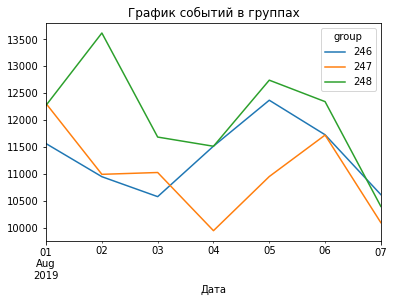

In [64]:
# Убедимся что у нас остались все 3 группы и как происходили события в группах
clean_data.pivot_table(index='date', columns='group', values='event_name', aggfunc={'event_name':'count'}).plot()
plt.title('График событий в группах')
plt.xlabel('Дата')
plt.show()

Мы убедились что все происходящие события происходят в 3 группах, никакая группа не исчезла. Тестируемая группа показывает лучшие результаты по количеству событый, только в последний день уступает лидерство.

### Вывод

Подготовили данные к дальнейшему анализу. 
- Убрали дни с события в которых произошло  минимальное их количество
- В данных были дубликаты, в общем данные теста уменшились на 1.5%
- В тессте присутвуют события 3 групп, пользователи по группам разделены на отлично. 
- В среднем каждый польззователь совершает 32 события.

## Пользовательская воронка

Проанализируем пользователей в разрезе совершенных их действий, необходимо посчитать сколько именно он их совершил и в каком количестве.

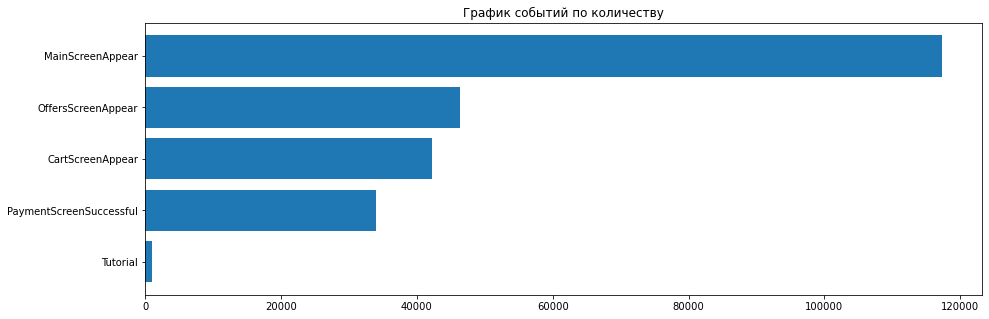

,event_name,cnt_events
0,Tutorial,1005
1,PaymentScreenSuccessful,33918
2,CartScreenAppear,42303
3,OffersScreenAppear,46333
4,MainScreenAppear,117328


In [65]:
# Общеее количество событий
temp = (
    clean_data.groupby('event_name', as_index=False)
    .agg({'date':'count'})
    .rename(columns={'date':'cnt_events'})
    .sort_values('cnt_events').reset_index(drop=True)
)

# Визуализация
plt.figure(figsize=(15, 5))
plt.barh(temp['event_name'], temp['cnt_events'])
plt.title('График событий по количеству')

plt.show()

temp

Как мы видим формируется пользвательская воронка, обучающий этап скорее всего не относится к ней.

Посчитаем количество событий и сколько уникальных пользователей совершили их, выведем конверсию по ним в воронке.

In [66]:
# Общее количество событий и количество пользователей совершивших их
events = (
    clean_data.groupby('event_name', as_index=False)['device_id']
    .agg(['count', 'nunique'])
    .sort_values('count', ascending=False)
    .rename(columns={'count':'cnt_events', 'nunique':'total_users'})
    .reset_index())

# Конвертация по событиям пользователей
events['conv_events'] = round(events['cnt_events']/ events['cnt_events'][0] * 100, 1)
events['conv_users'] = round(events['total_users']/events['total_users'][0] * 100, 1)
events.style.background_gradient('coolwarm')

,event_name,cnt_events,total_users,conv_events,conv_users
0,MainScreenAppear,117328,7419,100.000000,100.000000
1,OffersScreenAppear,46333,4593,39.500000,61.900000
2,CartScreenAppear,42303,3734,36.100000,50.300000
3,PaymentScreenSuccessful,33918,3539,28.900000,47.700000
4,Tutorial,1005,840,0.900000,11.300000


Посчитали количество пользователей посмотревших `главную страницу` - 7419 (100%), перешли на `предложение` уже  - 4593 (62%) пользователей, `добавили карту` - 3734 (50%), `совершили платеж` - 3539 (48%). `Обучающий этап` не пользуется популярностью его прошло 11% людей от общего количества, скорее всего пользователи считают интерфейс не таким сложным чтобы проходить его. Обучающий этап не стал бы вносить в воронку, так как из данных не ясно на каком этапе он предлагается пользователям. 

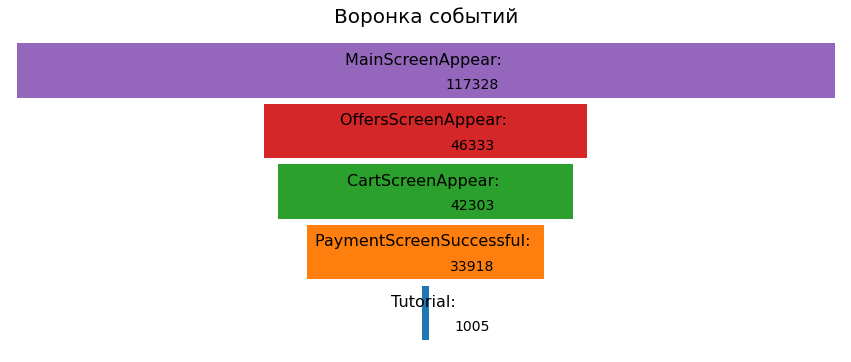

In [25]:
# Задать диапозон значений на граффике 
x_max = 120000
x_min = 0

# размер графика и расположение
fig, ax = plt.subplots(1, figsize=(15, 6))

labels = list(temp['event_name']) # Список событий
x = temp['cnt_events']            # Серия содержащая события
y = temp['event_name']            # Серия со значениями событий

# Создание воронки
for idx, val in enumerate(x):
    left= (x_max - val)/2 # отступ от левого края
    plt.barh(y[idx], x[idx], left=left, height=0.9) # График
    # Названия Событий
    plt.text(x_max/2, idx +0.1, labels[idx]+': ', ha='center', fontsize=16)
    # значения     
    plt.text(x_max/1.8, idx-.3, x[idx], ha='center', fontsize=14)
    
# Визуализация
plt.title('Воронка событий', fontsize=20)
plt.axis('off')
plt.xlim(x_min, x_max)
plt.show;

Сформировали наглядно покупательскую воронку событий. Этап с обучением необходимо убирать. И смотреть события в разрезу уже тестируемых групп.

In [102]:
# Убрать события "Tutorial"
clean_data = clean_data.query('event_name != "Tutorial"')

**Выводы**
1. Если смотреть по пользователям то:
- посмотрели `главный экран` 7419 перешли на `предложение` 4593 - удержание составляет 62%, потери существенные 
- далее `добавляют карту` только 3734 пользователя, на этом этапе удержание - 50%. Потери не критичные, но существеные, потеряли еще 11% пользвателей
- `Совершили покупку` только 3539 пользователей или 47% пользвателей от всех тестируемых  

Покупку совершал практически каждый второй пользователь, зашедший на сайт компании

2. Если смотреть по количеству событий то:
- Посмотрели `главный экран` всего - 117тысяч раз и перешли после этого на `предложение` 46тысяч раз, удержание составило 39%
- `Добавили карту` посмотрели 42тысячи, удержание 36%, на этом этапе не такие большие потери как по количеству клиентов, всего 3% потерь по  просмотрам
- А вот `страницу оплаты` просмотрели 28тыс, удержание составило 29% по событиям  

Очень часто просматривают главную страницу, либо очень часто приходиться к ней возвращаться или пользователи с нее уходят не определившись с предложениемю Но если посмотрят предложение скорее всего добавят карту для покупок.

## A/B тест

Разобьем данные на группы и узнаем сколько в них было человек

In [124]:
# Подсчитать каждое события для каждой группы
pivot_by_group = (
    clean_data.pivot_table(index=['group', 'event_name'],
                           values='device_id', aggfunc=['count', 'nunique'])
    
)

# Переименование колонок
pivot_by_group.columns = pivot_by_group.columns.droplevel(1) # Убираем мультииндекс
pivot_by_group = pivot_by_group.rename(columns={'count':'cnt_events', 'nunique':'cnt_users'}) # переименовали


# Сортировка по группам и значениям событиям от большего к меньшему
pivot_by_group=pivot_by_group.sort_values(['group', 'cnt_events'], ascending=False).reset_index()

# pivot_by_group['conv_users'] = round(pivot_by_group['cnt_users']/pivot_by_group['cnt_users'][0] * 100, 1)

pivot_by_group

,group,event_name,cnt_events,cnt_users
0,248,MainScreenAppear,40562,2493
1,248,OffersScreenAppear,16387,1531
2,248,CartScreenAppear,15179,1230
3,248,PaymentScreenSuccessful,12085,1181
4,247,MainScreenAppear,39090,2476
5,247,OffersScreenAppear,15179,1520
6,247,CartScreenAppear,12434,1238
7,247,PaymentScreenSuccessful,9981,1158
8,246,MainScreenAppear,37676,2450
9,246,OffersScreenAppear,14767,1542


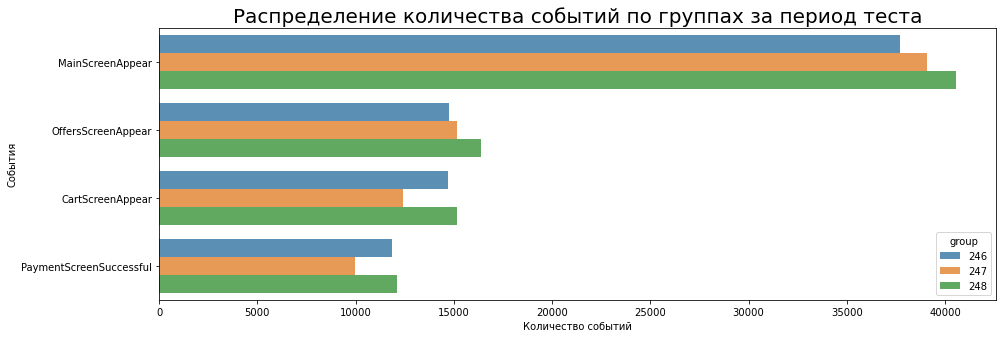

In [121]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=pivot_by_group,
                x='cnt_events', 
                y='event_name',
                hue='group',
                alpha=.8)

ax.set_title('Распределение количества событий по группах за период теста', fontsize=20)
ax.set(xlabel='Количество событий', ylabel='События');

In [153]:
pivot_by_group.query('event_name == "MainScreenAppear"')[['group', 'cnt_events', 'cnt_users']]

,group,cnt_events,cnt_users
0,248,40562,2493
4,247,39090,2476
8,246,37676,2450


Итого в группах было:
    **248** - 2493 пользвателя;
    **247** - 2475 пользователя;
    **246** - 2450 пользователя
    
Есть небольшие отличия по количеству, но нужно проверить статистические критерии разницы между выборками групп.

Собирем данные по дням для каждой группы, и для каждого события посчитаем количество произошедщий событий в это день и количество уникальных пользователей в этот день совершивших их. Благодаря ежедневным количествам посещений пользователей подсчитаем проверим гипотезу о равенстве среднего количества пользователей в каждой из групп.

Сформируем гипотезы:
- Н0: Группы сформираваны равномерно, количество пользователей в группах равны
- Н1: Группы не равны, количество пользователей сильно различается

In [154]:
# собираем данные по дням, группам, событиям
event_per_days = (
    clean_data.pivot_table(index=['date', 'group', 'event_name'],
                          values='device_id',
                          aggfunc=['count', 'nunique'])
).round(2).reset_index()

event_per_days.columns = ['date', 'group', 'event_name', 'cnt_events', 'cnt_users']

event_per_days = event_per_days.sort_values(['date', 'group', 'cnt_events'], ascending=False).reset_index(drop=True)

In [156]:
# выделиили отдельные срезы по количеству уникальных пользователей в день
sample_246 = event_per_days.query('group == 246 & event_name == "MainScreenAppear"')['cnt_users'].reset_index(drop=True)
sample_247 = event_per_days.query('group == 247 & event_name == "MainScreenAppear"')['cnt_users'].reset_index(drop=True)
sample_248 = event_per_days.query('group == 248 & event_name == "MainScreenAppear"')['cnt_users'].reset_index(drop=True)

alpha = 0.05

results_equeal_group_67 = st.ttest_ind(sample_246, sample_247)
results_equeal_group_68 = st.ttest_ind(sample_246, sample_248)
results_equeal_group_78 = st.ttest_ind(sample_247, sample_248)

bonferroni_alpha = alpha / 3  # произведено три сравнения

print('p-значение для сравнения групп 246 и 247: ', results_equeal_group_67.pvalue)
print('p-значение для сравнения групп 246 и 247: ', results_equeal_group_68.pvalue)
print('p-значение для сравнения групп 246 и 247: ', results_equeal_group_78.pvalue)


if results_equeal_group_67.pvalue < bonferroni_alpha:
    print('Отвераем нулевую гипотезу группы  246 и 247 не равны')
else:
    print('Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 247')
    

if results_equeal_group_68.pvalue < bonferroni_alpha:
    print('Отвераем нулевую гипотезу группы  246 и 248 не равны')
else:
    print('Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 248')
    

if results_equeal_group_78.pvalue < bonferroni_alpha:
    print('Отвераем нулевую гипотезу группы  247 и 248 не равны')
else:
    print('Не получилось отвергнуть нулевую гипотезу для сравнения групп 247 и 248')

p-значение для сравнения групп 246 и 247:  0.3935679120702118
p-значение для сравнения групп 246 и 247:  0.25278680233180467
p-значение для сравнения групп 246 и 247:  0.7816239522799555
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 247
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 248
Не получилось отвергнуть нулевую гипотезу для сравнения групп 247 и 248


,group,cnt_events,cnt_users
0,248,40562,2493
5,247,39090,2476
10,246,37676,2450


In [100]:
# критический уровень статической значемости 
# alpha = 0.05

# Количество в каждой группе
sample_248 = cnt_user_per_group.query('group==248')['cnt_users']
sample_247 = cnt_user_per_group.query('group==247')['cnt_users']
sample_246 = cnt_user_per_group.query('group==246')['cnt_users']

print(sample_246[0])

# results_246_247 = abs(int(sample_246[0])/ int(sample_247[0]))
# results_246_248 = st.ttest_ind(sample_246, sample_248)
# results_247_248 = st.ttest_ind(sample_248, sample_248)


bonferoni_alpha = alpha / 3

print('p-значение для сравнения групп 246 и 247: ', results_247_248.pvalue)
print('p-значение для сравнения групп 246 и 248: ', results_246_248.pvalue)
print('p-значение для сравнения групп 247 и 248: ', results_247_248.pvalue)

KeyError: 0

In [83]:
# Разбиваем по группам данные
group_246 = clean_data.query('group==246')[['device_id', 'event_name', 'event_date', 'date', 'days_of_week_event']]
group_247 = clean_data.query('group==247')[['device_id', 'event_name', 'event_date', 'date', 'days_of_week_event']]
group_248 = clean_data.query('group==248')[['device_id', 'event_name', 'event_date', 'date', 'days_of_week_event']]

In [84]:
clean_data

,event_name,device_id,event_timestamp,group,event_date,date,days_of_week_event
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01,Thursday
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01,Thursday
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01,Thursday
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01,Thursday
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01,Thursday
...,...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07,Wednesday
243709,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07,Wednesday
243710,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07,Wednesday
243711,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07,Wednesday


In [33]:
pivot_by_group

,group,event_name,cnt_events,cnt_users
0,248,MainScreenAppear,40562,2493
1,248,OffersScreenAppear,16387,1531
2,248,CartScreenAppear,15179,1230
3,248,PaymentScreenSuccessful,12085,1181
4,247,MainScreenAppear,39090,2476
5,247,OffersScreenAppear,15179,1520
6,247,CartScreenAppear,12434,1238
7,247,PaymentScreenSuccessful,9981,1158
8,246,MainScreenAppear,37676,2450
9,246,OffersScreenAppear,14767,1542



Шаг 5. Изучите результаты эксперимента
- Сколько пользователей в каждой экспериментальной группе?
- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
- Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
- Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
- Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.ь

In [34]:
# С помощью pivot_table() вычислите среднее время, проведённое на заправках в каждой из сетей, и сохраните результат в переменную stat.
# Выведите на экран значение переменной stat и проанализируйте полученные данные. Не забудьте, что time_spent хранит значения в секундах.
stat = pd.pivot_table(data, index=['name'], values='time_spent',  aggfunc={'time_spent':np.mean})



KeyError: 'time_spent'